# <div style="text-align: center"> <font size=+5> <ins>FIGURES for PAPER</ins> </font> </div>
___


# Import packages, settings and load variables

In [114]:
#imports
import numpy as np
import pandas as pd
import geopandas as gpd

import os

import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import PathPatch, Path

from scipy.stats import chi2_contingency
from scipy.stats import kruskal

from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

In [8]:
#settings
plt.rcParams.update({'figure.figsize': [6.0, 4.0],
                     'figure.dpi' : 300,
                     'font.size': 12.0, 
                     'mathtext.fontset' : 'stix', 
                     'font.family' : 'STIXGeneral'
                    })

pd.set_option('display.max_columns', 500)

In [118]:
#load variables

#geopandas worldmap
worldmap = gpd.GeoDataFrame(pd.read_pickle("../Processed_Data/misc/worldmap.pickle"))

#dataset with unclustered questions (answers converted to numerical ranges, no indicators)
questions_dataset = pd.read_pickle("../Saved_variables/data_issp_questions_numerical.pickle").droplevel(axis=1, level=0)

#full dataset with clustered questions, individual and country-wide indicators (individual indicators as categories)
full_dataset = pd.read_pickle("../Saved_variables/full_dataset.pickle")

#full dataset with categorical variables converted to numerical
conv_dict_respData = {
        "Sex" : {"Male" : -1, "Female" : 1},
        "Education level" : {"No degree" : 0, "Primary" : 1, "Secondary" : 2, "University" : 3},
        "Living area" : {"Rural area" : 0, "Small city" : 1, "Big city" : 2},
        "Political orientation" : {"Far Left" : -3, "Left" : -2, "Center Left" : -1, "Center" : 0, "None/Other" : 0, "Center Right" : 1, "Right" : 2, "Far Right" : 3},
        "Religious beliefs" : {"Atheist" : 0, "Christian" : 1, "Islamic" : 1, "Jewish" : 1, "Other" : 1}
    }

data_resp_numerical = full_dataset.loc[:, ("Respondent Data", slice(None))].apply(lambda col: col if col.name[1] not in conv_dict_respData else col.map(lambda x: np.nan if pd.isna(x) else conv_dict_respData[col.name[1]][x]).astype(float))
full_dataset_numerical = full_dataset.drop(columns=["Respondent Data"])
full_dataset_numerical = pd.concat([data_resp_numerical, full_dataset], axis=1)

#dataset with all downloaded indicators
macro_indicators_dict = {(ind[:-7]) : pd.read_pickle(f"../Processed_Data/indicators/{ind}") for ind in os.listdir("../Processed_Data/indicators") if ind[-7:] == ".pickle"}
macro_ind_df = pd.concat([pd.DataFrame.from_records([full_dataset.index.droplevel("Unique ID").unique().map(lambda idx: indicator.loc[idx[1], idx[0]]) for indicator in macro_indicators_dict.values()], index=macro_indicators_dict.keys(), columns=full_dataset.index.droplevel("Unique ID").unique()).T], keys=["Country-wide indicators"], names=["Variable Type", "Variable Name"], axis=1)

newcols = {
    "GHG_emissions"     : "Greenhouse gases emissions",
    "PM25_exposure"     : "PM25 exposure",
    "GDP_growth"        : "GDP growth",
    "gini_index"        : "Gini index",
    "GDP_pcap_ppp"      : "GDP per capita (Purchasing Power Parity)",
    "water_withdrawals" : "Water withdrawals",
    "pesticides_use"    : "Pesticides use",
    "GDP_pcap"          : "GDP per capita",
    "internet_usage"    : "Internet usage",
    "CO2_emissions_per_capita" : "CO2 emissions per capita",
    "infant_mortality"  : "Infant mortality"
          }

newcols = {("Country-wide indicators", key) : ("Country-wide indicators", value) for key, value in newcols.items()}
macro_ind_df.columns = macro_ind_df.columns.map(lambda x: newcols.get(x,x))
del(macro_indicators_dict, newcols)


#series with belonging cluster for each country
countries_cluster = pd.read_pickle("../Saved_variables/countries_cluster.pickle")

#predictive modeling results
recapTable_tensorflow = pd.read_pickle("../Saved_variables/predictive_indicators_merged_tensorflow.pickle")
recapTable_mixedLM = pd.read_pickle("../Saved_variables/predictive_indicators_mixedLM.pickle")
recapTable_trees = pd.read_pickle("../Saved_variables/predictive_indicators_trees.pickle")

#env concern dimension conversions for plot titles
titleTopic = {
        "Awareness" : "Awareness",
        "Will to make sacrifices" : "Will",
        "Efficacy of environmental action" : "EnvEff"
    }

/var/folders/mv/3xxn6x011nj1xbbrht5z6r1m0000gn/T/ipykernel_822/811772476.py:22: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  full_dataset_numerical = full_dataset.drop(columns=["Respondent Data"])


___
# Workflow (TODO)

___
# Correlations

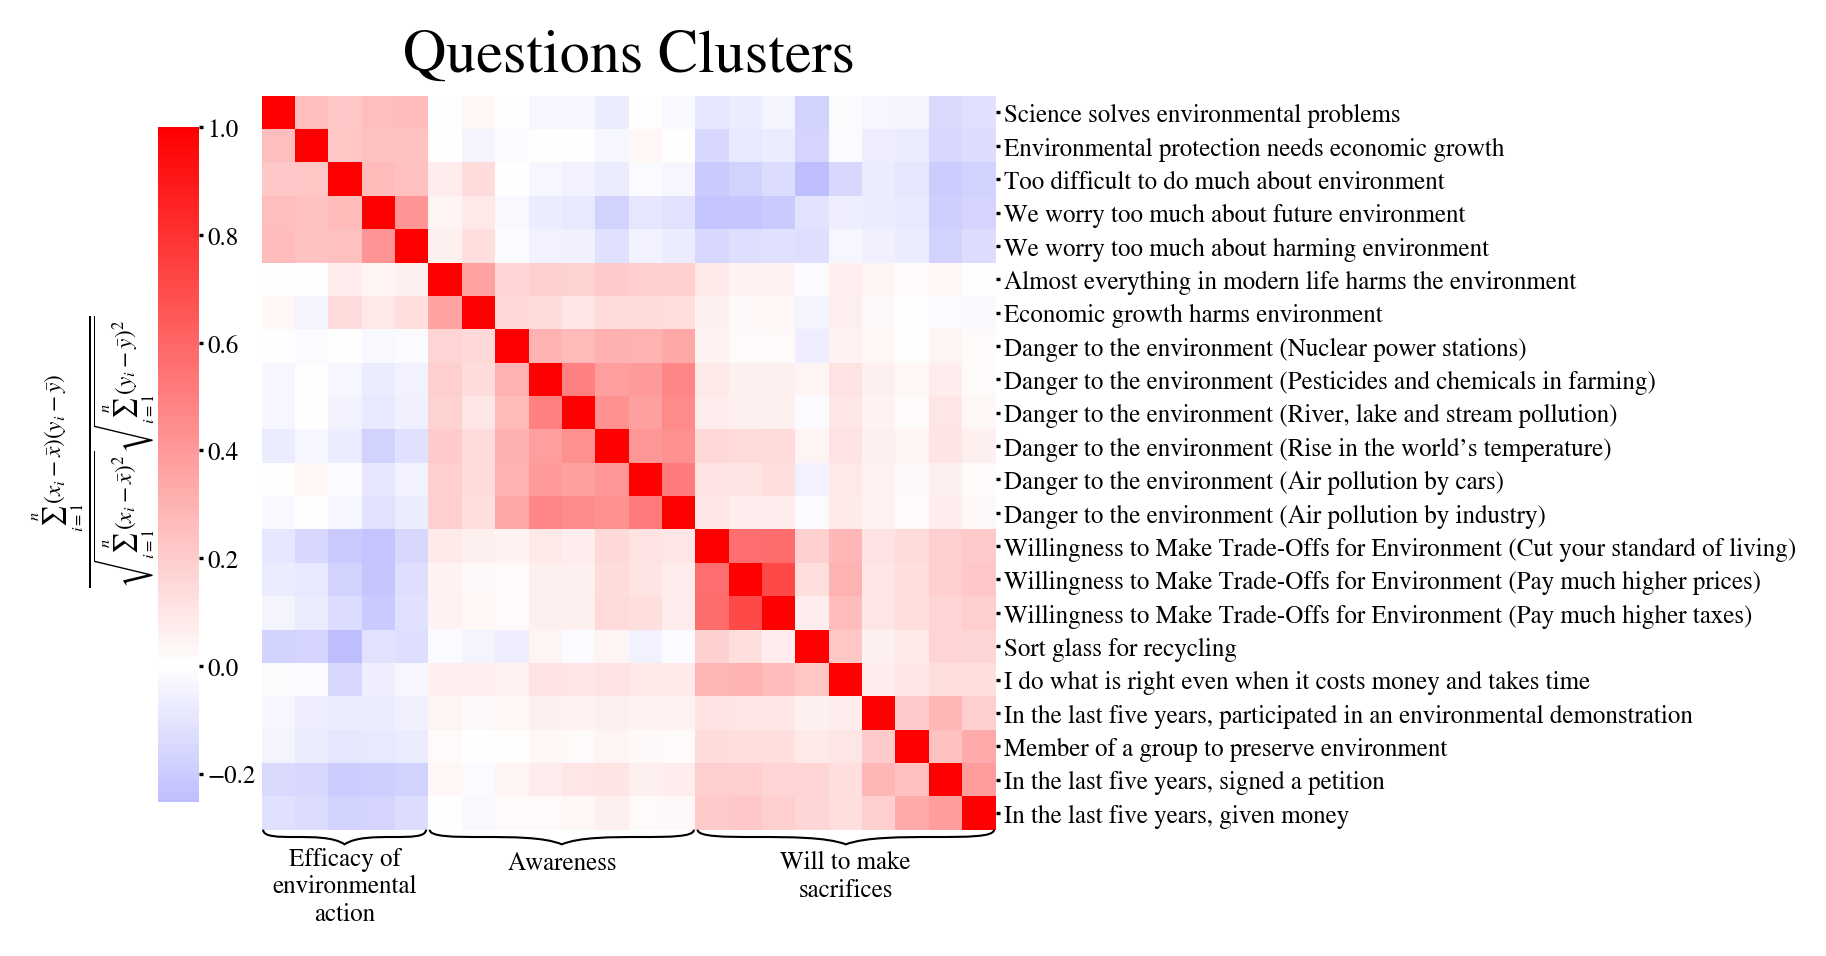

In [56]:
def CurlyBrace(x, y, width=1/8, height=1., curliness=1/np.e, pointing='left', **patch_kw):
    verts = np.array([
           [width,0],
           [0,0],
           [width, curliness],
           [0,.5],
           [width, 1-curliness],
           [0,1],
           [width,1]
           ])
    
    if pointing == 'left':
        pass
    elif pointing == 'right':
        verts[:,0] = width - verts[:,0]

    verts[:,1] *= height

    #horizontal rather than vertical
    verts = verts[:,::-1]
    
    verts[:,0] += x
    verts[:,1] += y

    
    
    codes = [Path.MOVETO,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             ]

    path = Path(verts, codes)

    # convert `color` parameter to `edgecolor`, since that's the assumed intention
    patch_kw['edgecolor'] = patch_kw.pop('color', 'black')

    pp = PathPatch(path, facecolor='none', **patch_kw) 
    return pp


clm = sns.clustermap(questions_dataset.corr(), cmap="bwr", center=0, cbar_pos=(0.05, 0.65, 0.015, 0.25), method="ward", figsize=(9,9))
clm.ax_row_dendrogram.set_visible(False)
clm.ax_col_dendrogram.set_visible(False)
clm.tick_params(size=1, pad=1, labelsize=6)

#clm.ax_heatmap.set_title("Environmental concern dimensions", fontsize=20);
clm.ax_heatmap.set_xticks([])
clm.ax_heatmap.set_xlabel("")
clm.ax_heatmap.set_ylabel("")
clm.ax_cbar.text(x=-1.6, y=0.4, s=r"$\frac{\sum_{i=1}^n (x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_{i=1}^n (x_i - \bar{x})^2} \sqrt{\sum_{i=1}^n (y_i - \bar{y})^2}}$", fontsize=8, rotation=90, va='center', ha='center')

brace = CurlyBrace(x=0.002, y=-0.02, width=.02, height=0.222, pointing='left', transform=clm.ax_heatmap.transAxes, color='black', linewidth=0.5)
clm.fig.patches.append(brace)
clm.ax_heatmap.text(x=2.5, y=23.7, s="Efficacy of\nenvironmental\naction", fontsize=6, rotation=0, va='center', ha='center')

brace = CurlyBrace(x=0.229, y=-0.02, width=.02, height=0.36, pointing='left', transform=clm.ax_heatmap.transAxes, color='black', linewidth=0.5)
clm.fig.patches.append(brace)
clm.ax_heatmap.text(x=9, y=23, s="Awareness", fontsize=6, rotation=0, va='center', ha='center')

brace = CurlyBrace(x=0.594, y=-0.02, width=.02, height=0.404, pointing='left', transform=clm.ax_heatmap.transAxes, color='black', linewidth=0.5)
clm.fig.patches.append(brace)
clm.ax_heatmap.text(x=17.5, y=23.4, s="Will to make\nsacrifices", fontsize=6, rotation=0, va='center', ha='center')

clm.ax_heatmap.set_title("Questions Clusters");

clm.savefig("../PaperFigures/questions_clusters.pdf", format="pdf")

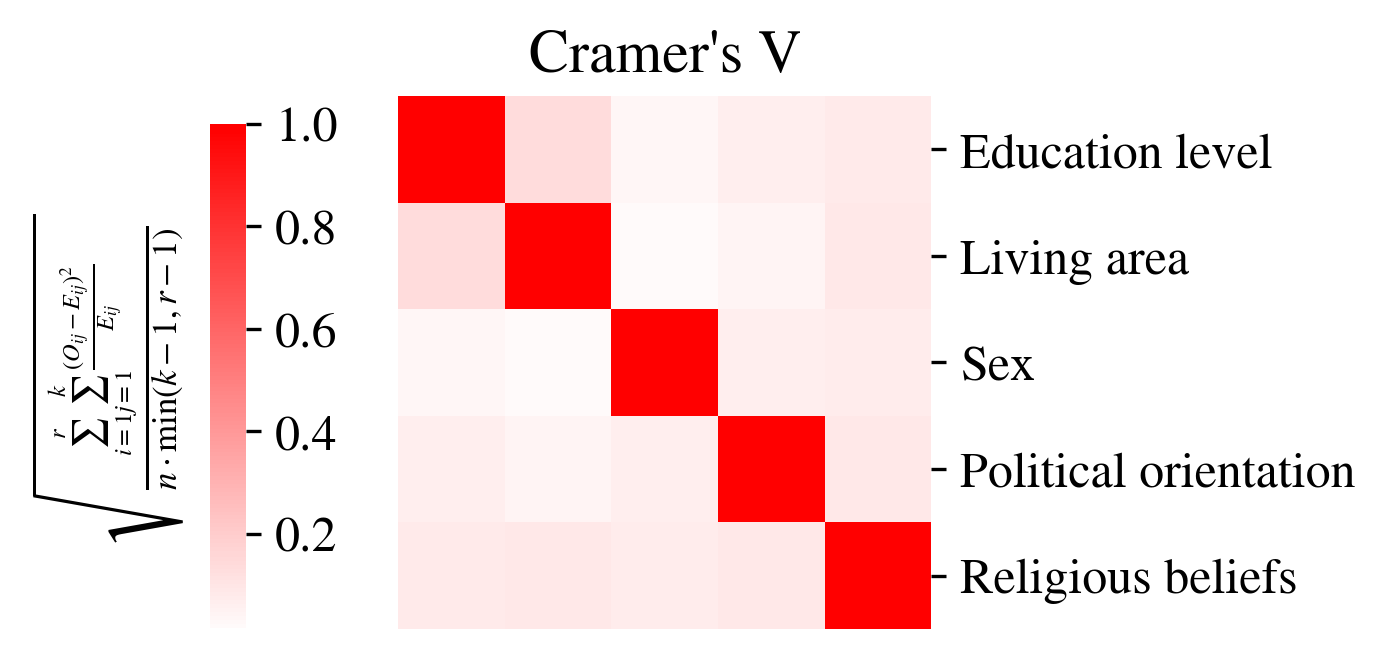

In [57]:
micro_ind_df = full_dataset.loc[:,"Respondent Data"].select_dtypes(include="category").dropna()
corr_matrix = pd.DataFrame(1, index=micro_ind_df.columns.values, columns=micro_ind_df.columns.values, dtype="float")

for i in corr_matrix.index:
    for j in corr_matrix.columns:
        if i != j:
            crosstab = pd.crosstab(micro_ind_df[i], micro_ind_df[j])
            chi2 = chi2_contingency(crosstab)[0]
            n = crosstab.sum().sum()
            phi2 = chi2/n
            r,k = crosstab.shape
            phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
            rcorr = r - ((r-1)**2)/(n-1)
            kcorr = k - ((k-1)**2)/(n-1)
            corr_matrix.loc[i,j] = np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

clm = sns.clustermap(corr_matrix, center=0, cmap="bwr", cbar_pos=(0, 0.4, 0.03, 0.42), method="ward", figsize=(4,4))
clm.ax_row_dendrogram.set_visible(False)
clm.ax_col_dendrogram.set_visible(False)
#clm.tick_params(size=1, pad=1, labelsize=6)
#clm.ax_heatmap.set_yticklabels(clm.ax_heatmap.get_ymajorticklabels(), fontsize=10, rotation=0)
#clm.ax_cbar.set_yticklabels(clm.ax_cbar.get_ymajorticklabels(), fontsize=10)

#clm.ax_heatmap.set_title("Cramér's V for categorical micro indicators", fontsize=20);
clm.ax_heatmap.set_xticks([])
clm.ax_heatmap.set_xlabel("")
clm.ax_heatmap.set_ylabel("")

clm.ax_cbar.text(x=-5, y=0.5, s=r"$\sqrt{\frac{\sum_{i=1}^r \sum_{j=1}^k \frac{(O_{ij} - E_{ij})^2}{E_{ij}}}{n \cdot \min(k-1, r-1)}}$", rotation=90, va="center")

clm.ax_heatmap.set_title("Cramer's V");

clm.savefig("../PaperFigures/categorical_cramerV.pdf", format="pdf")

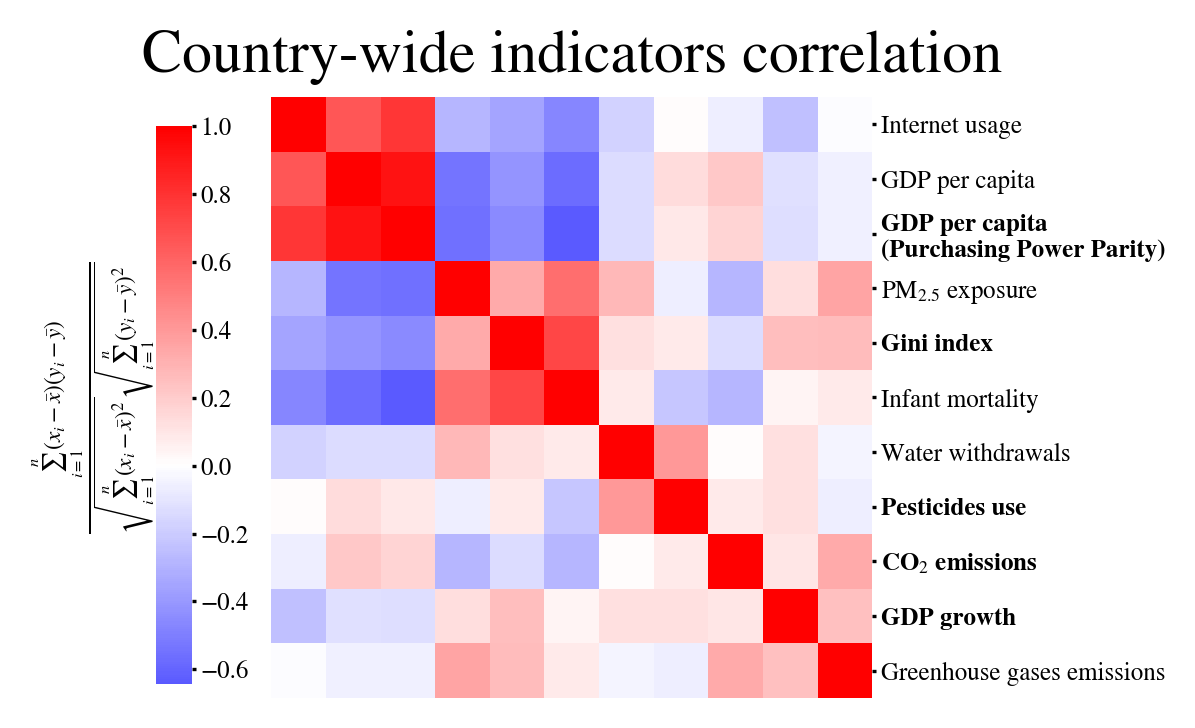

In [58]:
corr_matrix = macro_ind_df.corr()
corr_matrix.columns = corr_matrix.columns.droplevel(0)
corr_matrix.index = corr_matrix.index.droplevel(0)

clm = sns.clustermap(corr_matrix, cmap="bwr", center=0, cbar_pos=(0.05, 0.56, 0.02, 0.31), method="ward", figsize=(6,6))
clm.ax_row_dendrogram.set_visible(False)
clm.ax_col_dendrogram.set_visible(False)
clm.tick_params(size=1, pad=1, labelsize=6)
#clm.ax_heatmap.set_yticklabels(clm.ax_heatmap.get_ymajorticklabels(), fontsize=10)
#clm.ax_cbar.set_yticklabels(clm.ax_cbar.get_ymajorticklabels(), fontsize=10)

#clm.ax_heatmap.set_title("Correlations between macro indicators", fontsize=20);
clm.ax_heatmap.set_xticks([])
clm.ax_heatmap.set_xlabel("")
clm.ax_heatmap.set_ylabel("")

clm.ax_cbar.text(x=-3.5, y=0.2, s=r"$\frac{\sum_{i=1}^n (x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_{i=1}^n (x_i - \bar{x})^2} \sqrt{\sum_{i=1}^n (y_i - \bar{y})^2}}$",fontsize=8, rotation=90, va="center")

macro_indicators = ["GDP growth", "Gini index", "GDP per capita (Purchasing Power Parity)", "Pesticides use", "CO2 emissions per capita"]
corr_labels = {
                    "GDP per capita (Purchasing Power Parity)" : "GDP per capita\n(Purchasing Power Parity)",
                    "CO2 emissions per capita" : r"CO${}_2$ emissions",
                    "PM25 exposure" : r"PM${}_{2.5}$ exposure"
                }

ticklabels_old = [t.get_text() for t in clm.ax_heatmap.get_yticklabels()]
ticklabels_new = [corr_labels.get(t.get_text(), t.get_text()) for t in clm.ax_heatmap.get_yticklabels()]
clm.ax_heatmap.set_yticklabels(ticklabels_new)

for i,tick_label in enumerate(clm.ax_heatmap.get_yticklabels()):
    if ticklabels_old[i] in macro_indicators:
        tick_label.set_fontweight("black")

clm.ax_heatmap.set_title("Country-wide indicators correlation");
        
clm.savefig("../PaperFigures/country-wide_correlation.pdf", format="pdf")

___
# Clustering

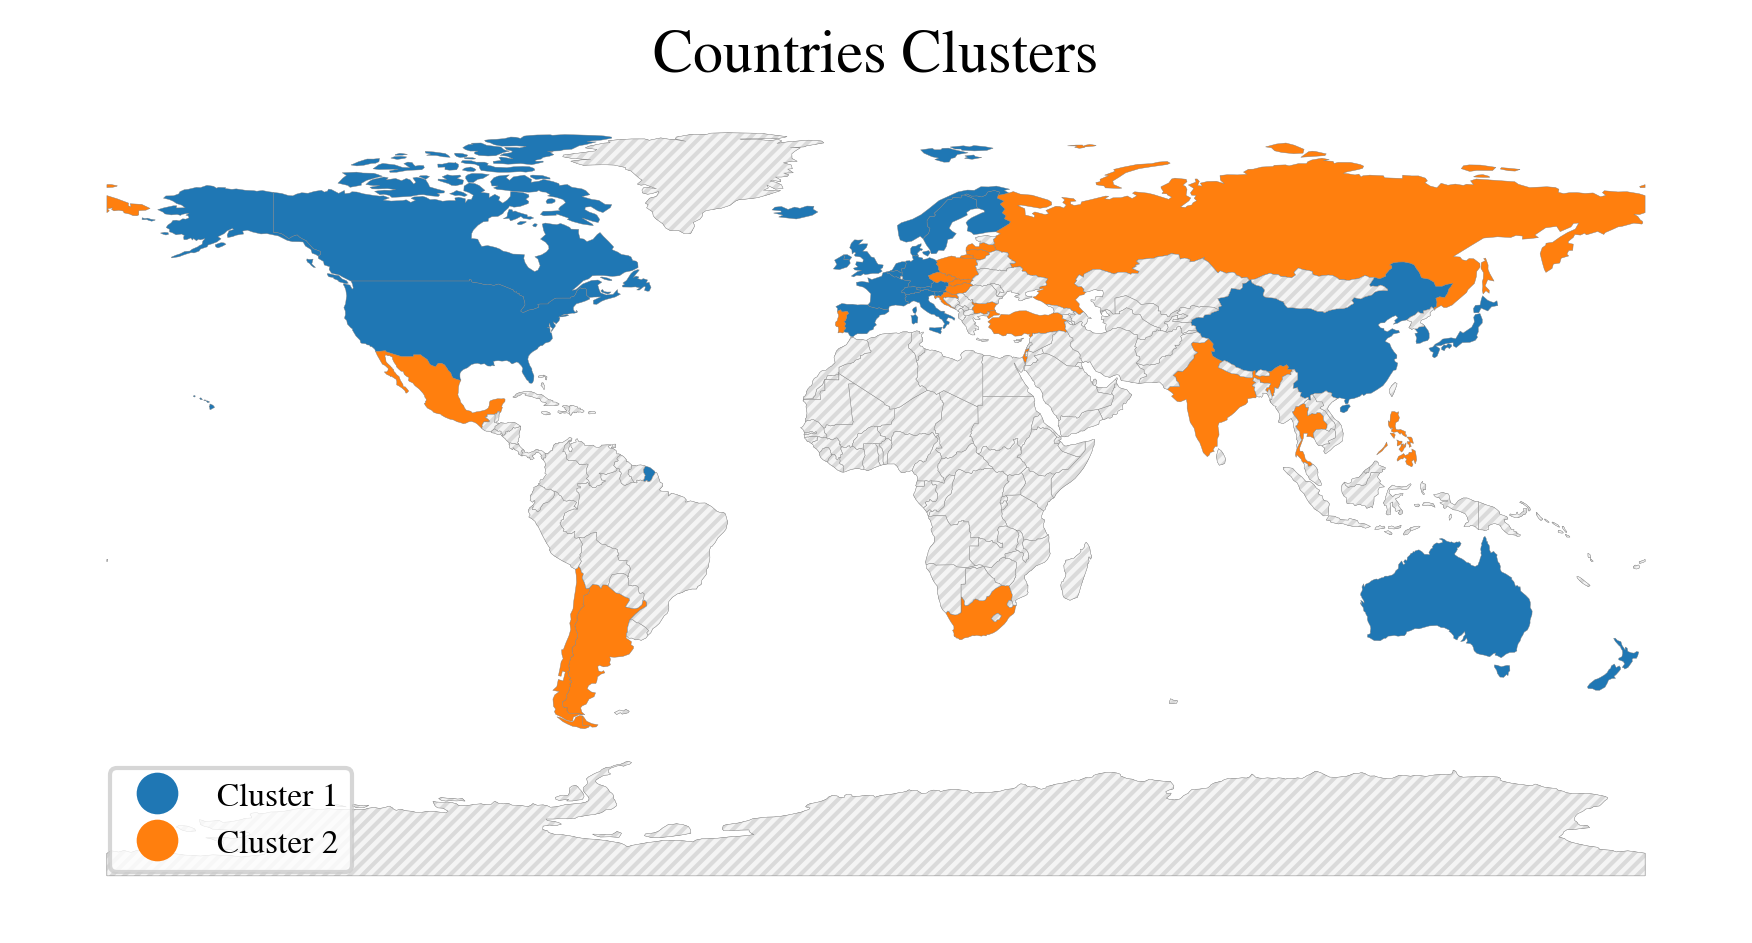

In [100]:
data = full_dataset.loc[:, "Environmental concern dimension"].groupby("Country").mean().reset_index()
data["cluster"] = data["Country"].map(lambda x: 0 if countries_cluster[x] == "Cluster 1" else 1)
data = data.set_index("Country")

worldmap.index.name = "Country"
c_names = {
    "United States of America" : "United States",
    "South Korea" : "South Korea",
    "Turkey" : "Turkiye",
}
worldmap.index = worldmap.index.map(lambda c: c_names.get(c,c))
worldmap_issp = worldmap.loc[[c for c in worldmap.index if c in data.index]]
worldmap_other = worldmap.loc[[c for c in worldmap.index if c not in data.index]]

fig, ax = plt.subplots()

cmap = mpl.colors.ListedColormap(['tab:blue', 'tab:orange'])

worldmap_issp["cluster"] = data["cluster"].astype("category")
worldmap_issp = worldmap_issp.sort_values(by=["cluster"])
worldmap_issp.plot(column="cluster", cmap=cmap, edgecolor="grey", linewidth=0.1, ax=ax, legend=True)
worldmap_other.plot(color=[1,1,1], edgecolor="gray", linewidth=0.1, hatch="////////", ax=ax)
worldmap_other.plot(edgecolor="gray", linewidth=0.1, color=[0.95,0.95,0.95], alpha=0.8, ax=ax)
ax.axis("off")

handles = ax.get_legend().legend_handles

ax.get_legend().remove()
plt.legend(handles,["Cluster 1", "Cluster 2"], fontsize=8, loc=(.0475,.05))
ax.get_legend().handletextpad = 0

ax.set_title("Countries Clusters")

fig.tight_layout()
fig.savefig(f"../PaperFigures/countries_clusters.pdf", format="pdf")

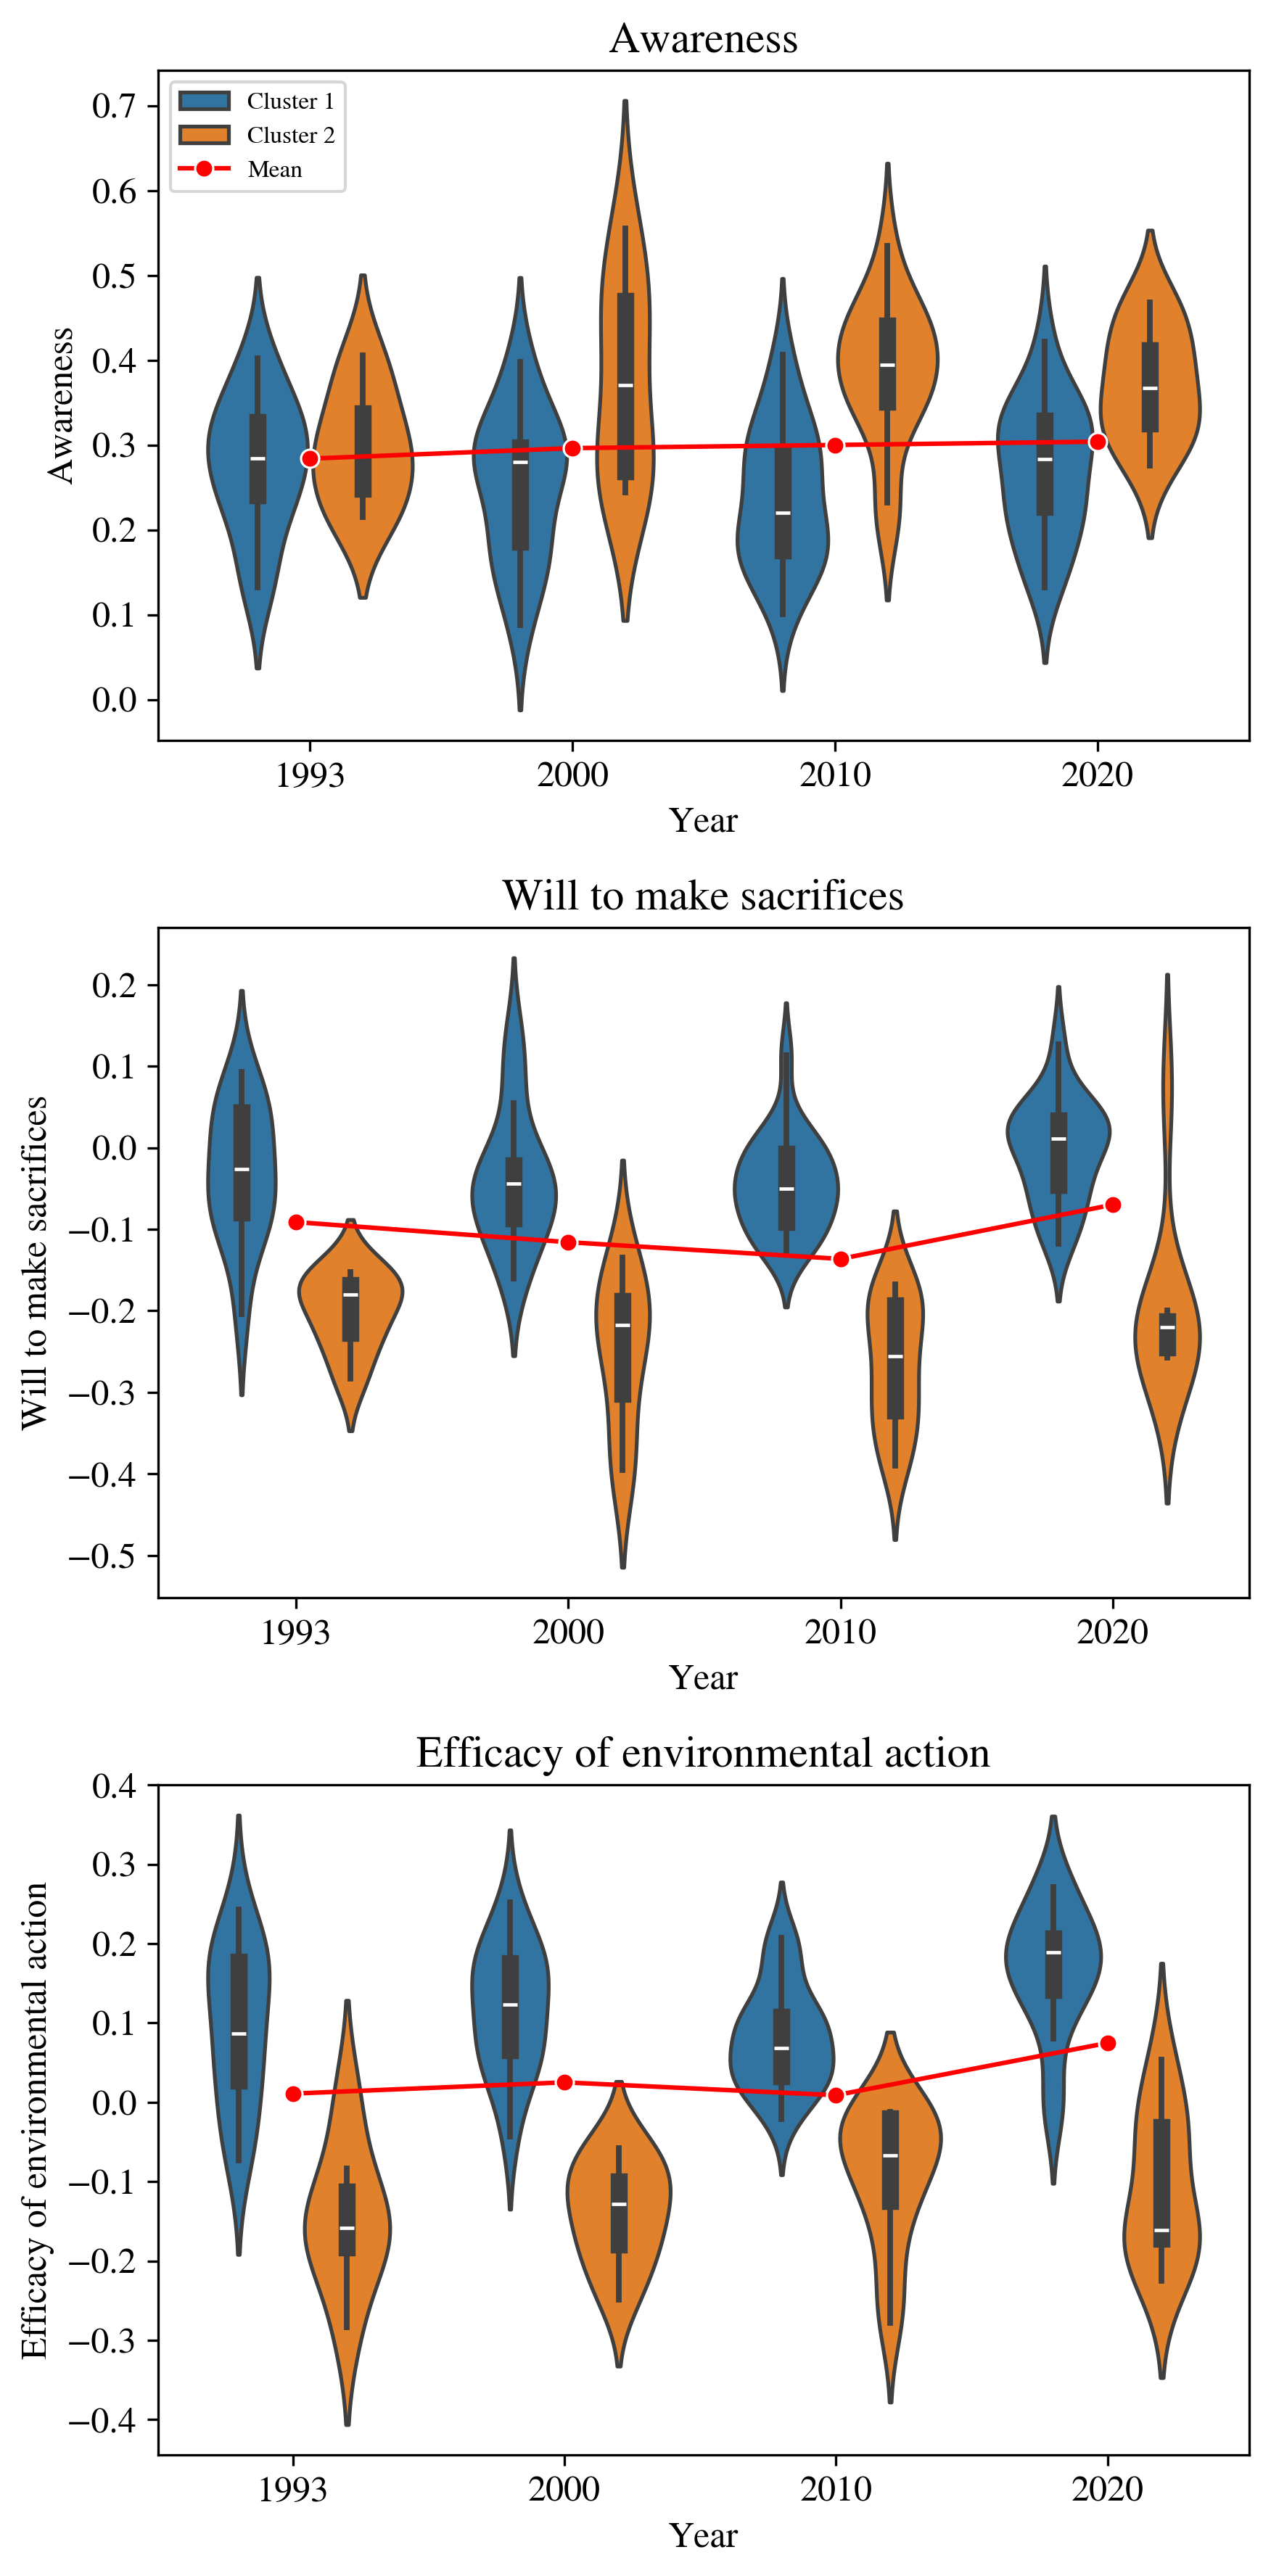

In [108]:
fsize = plt.rcParams["figure.figsize"]

fig, axs = plt.subplots(3, 1, figsize=(fsize[0], fsize[1]*3))
for i,topic in enumerate(full_dataset.loc[:,"Environmental concern dimension"].columns):
    ax = axs[i]
    ax.set_title(f"{topic}")
    df = full_dataset.loc[:,"Environmental concern dimension"].groupby(["Year", "Country"]).mean().reset_index()
    df["Cluster"] = df["Country"].map(countries_cluster)
    df = df.sort_values(by=["Cluster"])

    cmap = sns.color_palette(["tab:blue", "tab:orange"])
    sns.violinplot(data=df, x="Year", y=topic, hue="Cluster", palette=cmap, gap=0.05, ax=ax)
    
    # Calculate the mean for each category to plot as a trendline
    category_means = df.groupby('Year')[topic].mean().reset_index().reset_index()

    # Add a trendline based on the category means
    sns.lineplot(x="index", y=topic, data=category_means, marker='o', color='red', label="Mean",ax=ax)
    
    #fix legend labels order, only plot in first subplot
    if i==0:
        handles, labels = ax.get_legend_handles_labels()
        dict_labels = {label : handles[i] for i,label in enumerate(labels)}
        new_labels = sorted(labels)
        handles = [dict_labels[label] for label in new_labels]
        ax.legend(handles, new_labels, loc="upper left", fontsize=8)
    else:
        ax.get_legend().remove()

    if False: #plot legend for all plots
        handles, labels = ax.get_legend_handles_labels()
        dict_labels = {label : handles[i] for i,label in enumerate(labels)}
        new_labels = sorted(labels)
        handles = [dict_labels[label] for label in new_labels]
        ax.legend(handles, new_labels, loc="best", fontsize=8)
        
    plt.tight_layout()

    
fig.savefig(f"../PaperFigures/envConcern_vs_years_clustered.pdf", format="pdf")

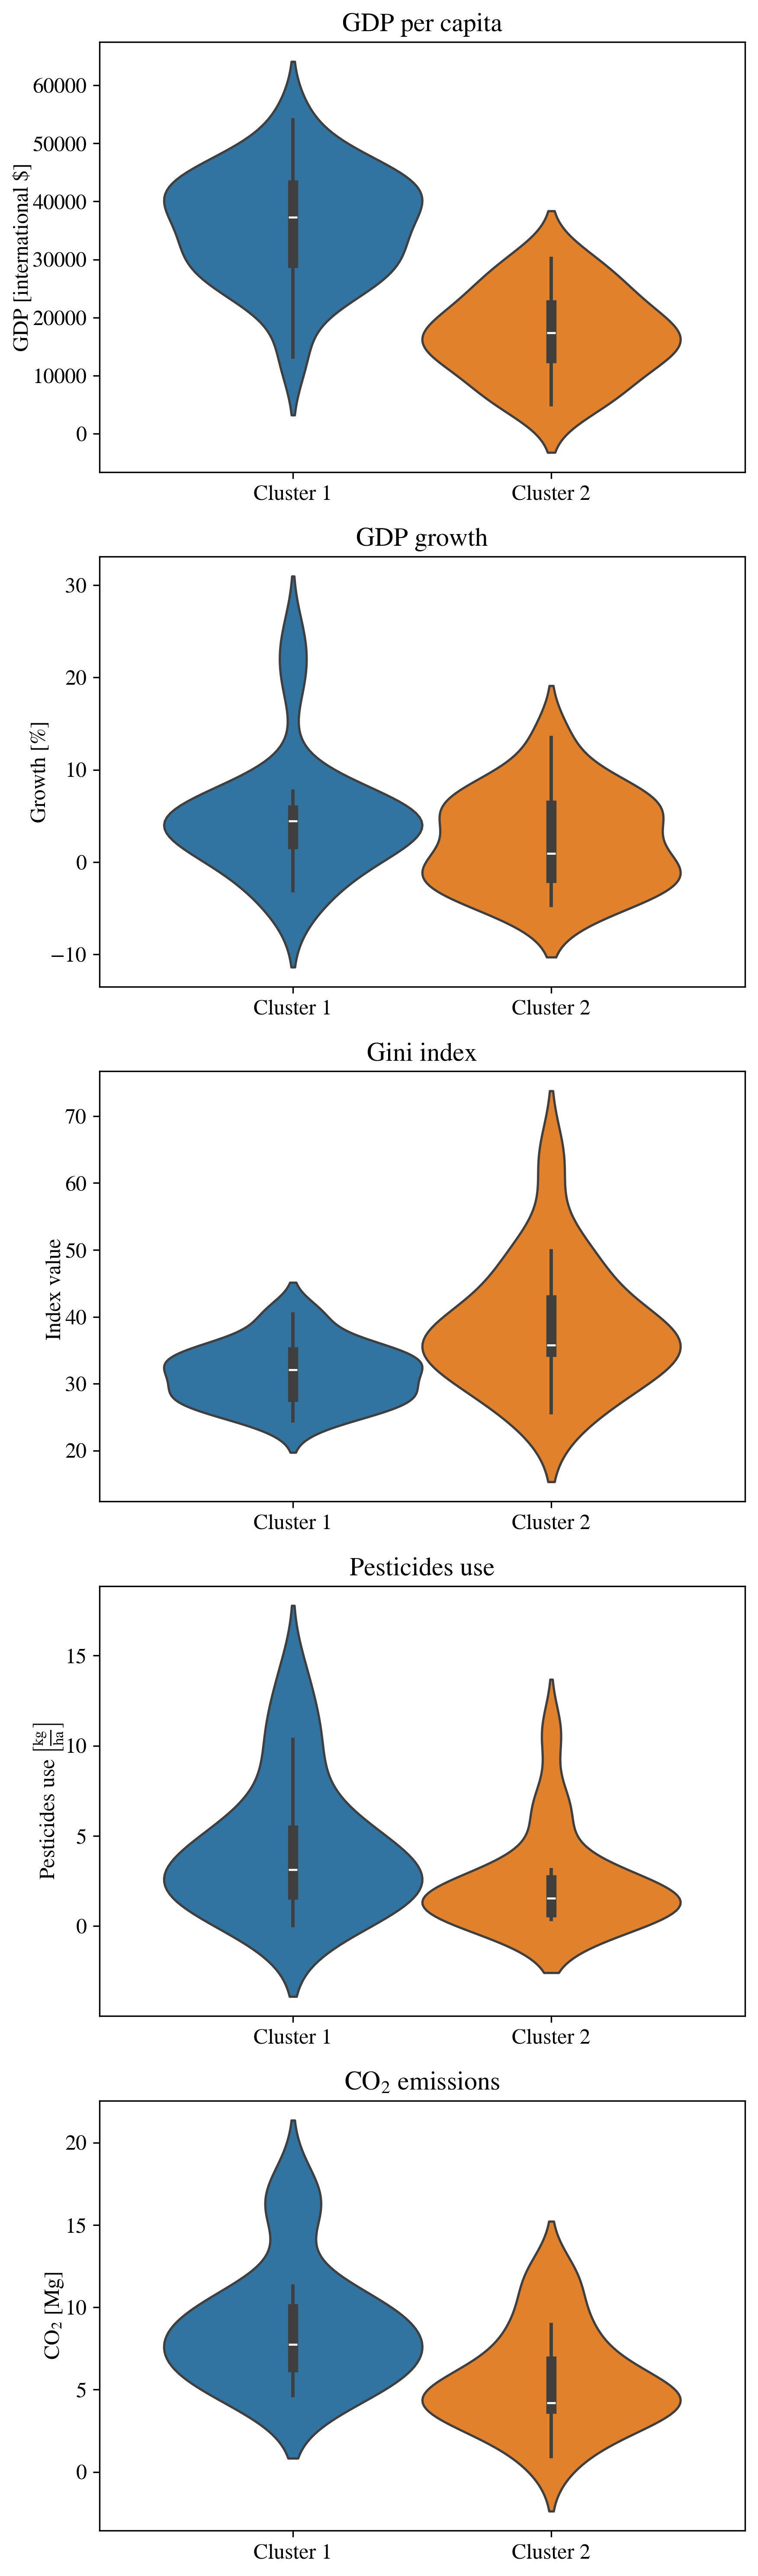

In [104]:
macro_ind = ["GDP per capita (Purchasing Power Parity)", "GDP growth", "Gini index", "Pesticides use", "CO2 emissions per capita"]

data = macro_ind_df.groupby("Country").mean()
data["Cluster"] = data.index.map(countries_cluster)
data = data.sort_values(by="Cluster")

fig, axs = plt.subplots(len(macro_ind),1 , figsize=(6, 4*len(macro_ind)))

cmap = sns.color_palette(["tab:blue", "tab:orange"])

for i,indicator in enumerate(macro_ind):
    ax = axs[i]
    
    sns.violinplot(data, hue="Cluster", y=("Country-wide indicators", indicator), ax=ax, palette=cmap)

    ax.set_xticks([-0.2,0.2])
    ax.set_xticklabels(["Cluster 1", "Cluster 2"])
    ax.get_legend().remove()

    titles = {
                    "GDP per capita (Purchasing Power Parity)" : "GDP per capita",
                    "CO2 emissions per capita" : r"CO${}_2$ emissions",
                }
    
    x_axis_units = {
        "CO2 emissions per capita" : "[Mg]",
        "GDP growth" : "[%]",
        "GDP per capita (Purchasing Power Parity)" : "[international $]",
        "Pesticides use" : r"$\left[\frac{\text{kg}}{\text{ha}}\right]$"    
    }
    
    x_axis_labels = {
        'GDP growth': 'Growth',
        'Gini index': 'Index value',
        'GDP per capita (Purchasing Power Parity)': 'GDP',
        'CO2 emissions per capita': r'CO${}_2$'
    }

    ax.set_title(f"{titles.get(indicator, indicator)}")
    ax.set_ylabel(f"{x_axis_labels.get(indicator, indicator)}"+f" {x_axis_units.get(indicator, '')}", loc="center", labelpad=0)

fig.tight_layout()

fig.savefig("../PaperFigures/indicators_vs_countryClusters.pdf", format="pdf")

___
# Effect of indicators

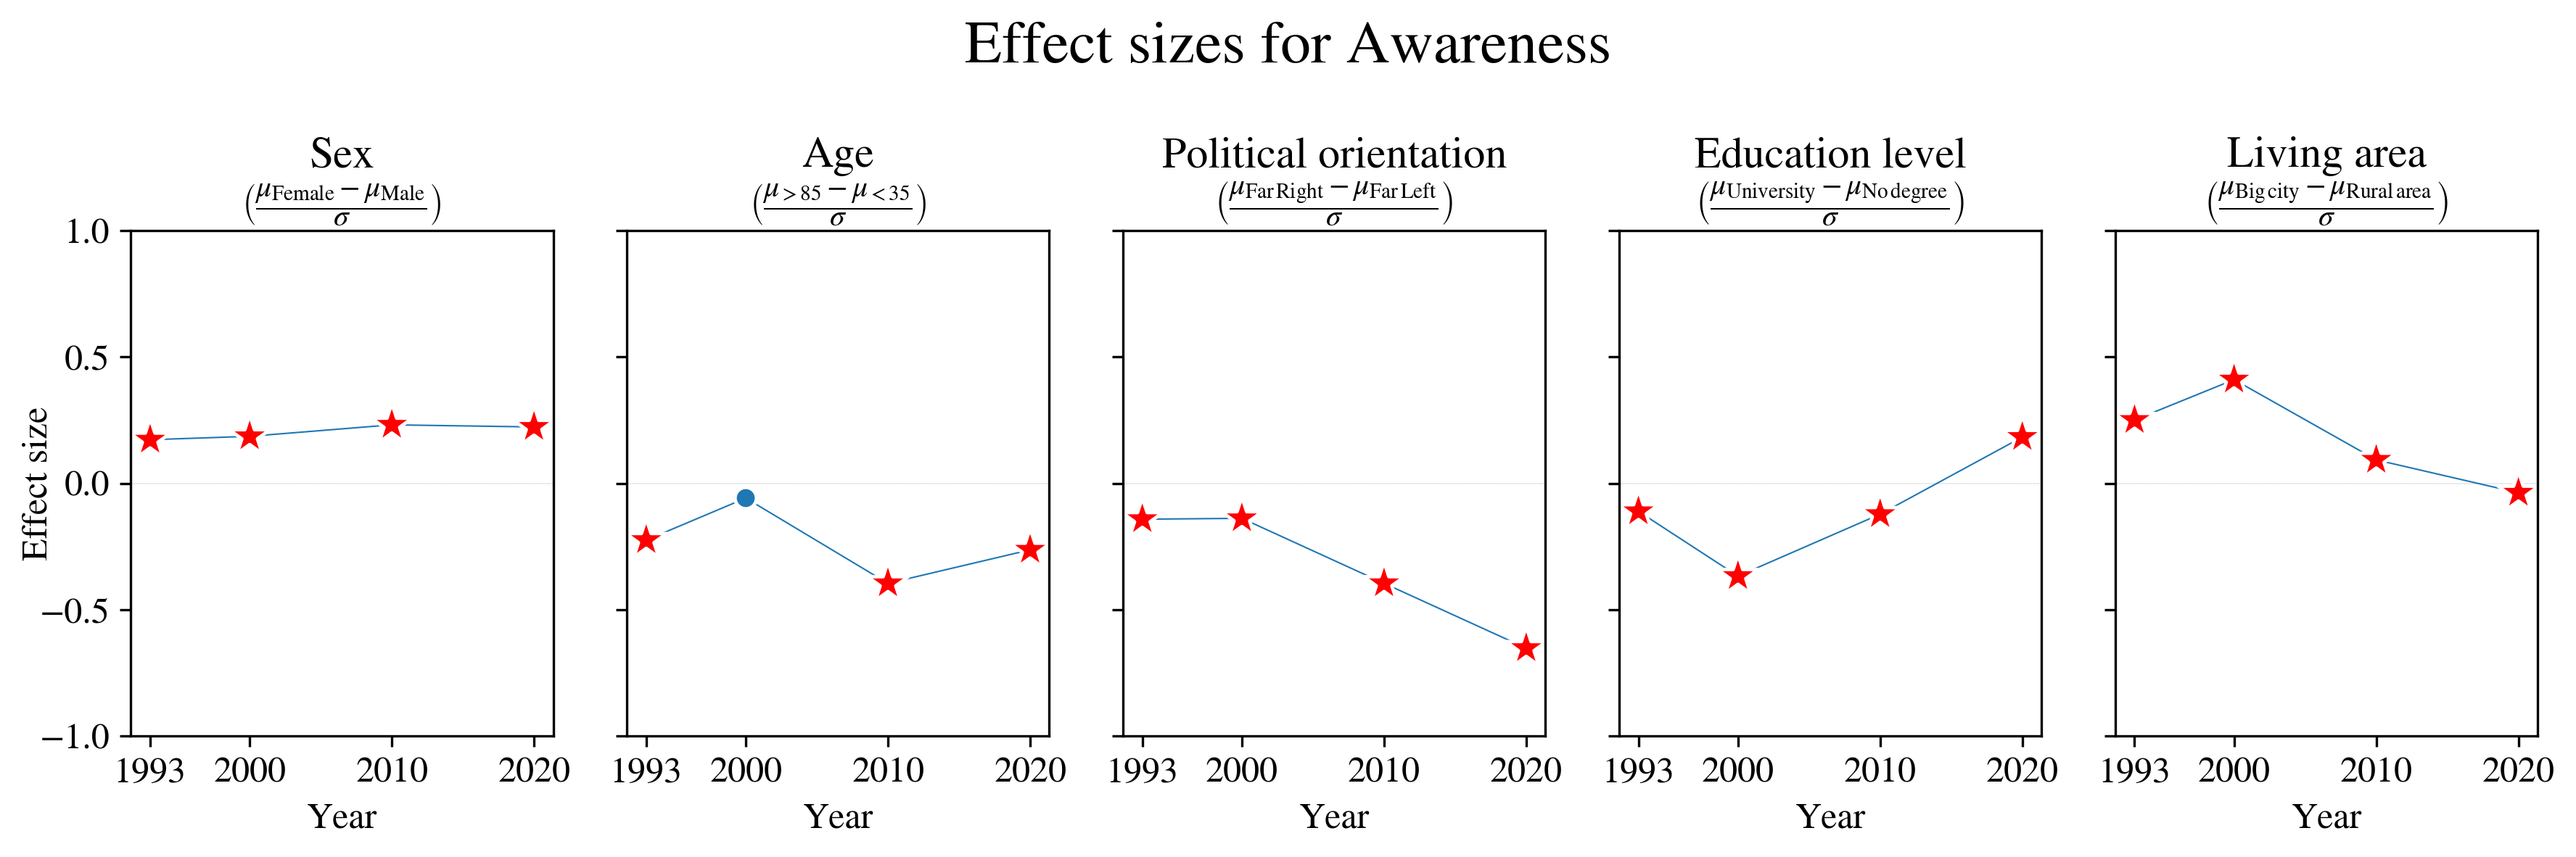

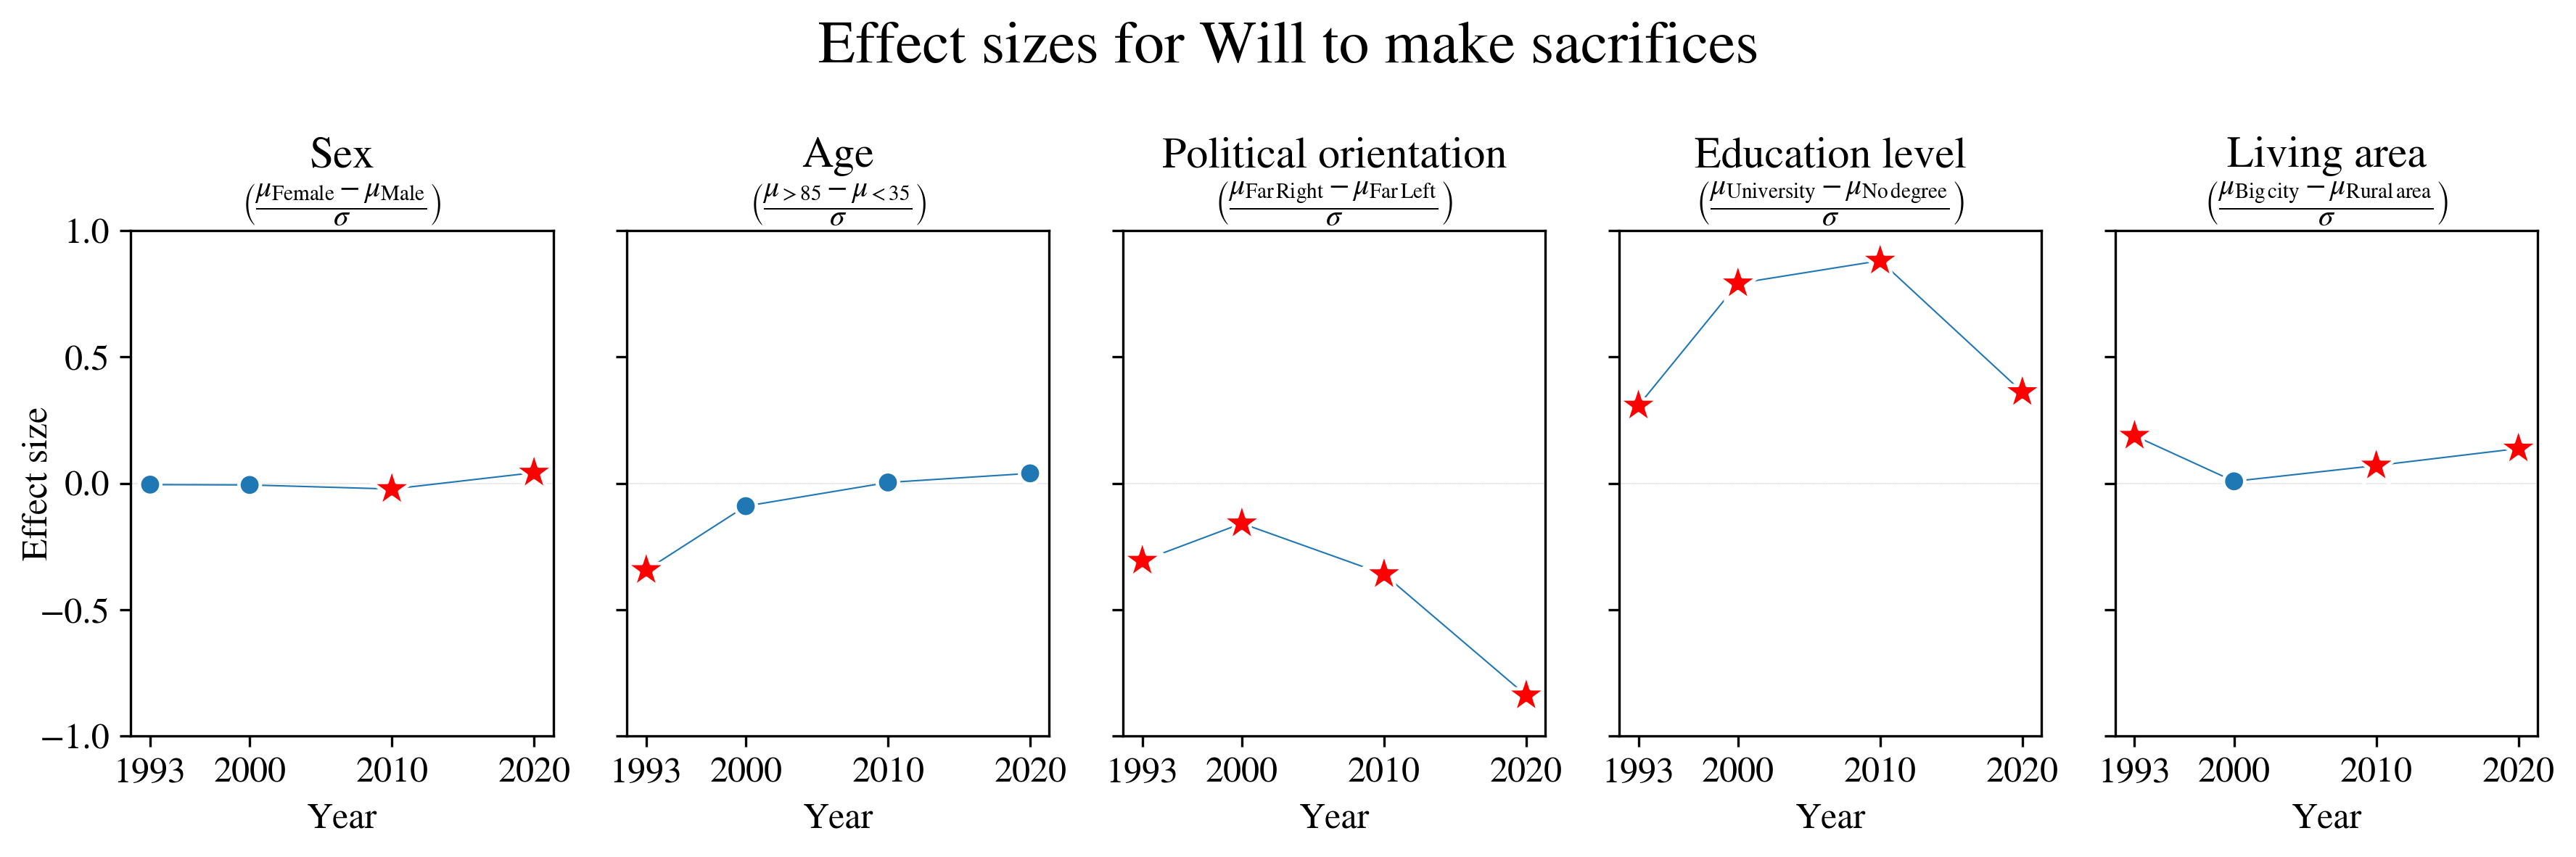

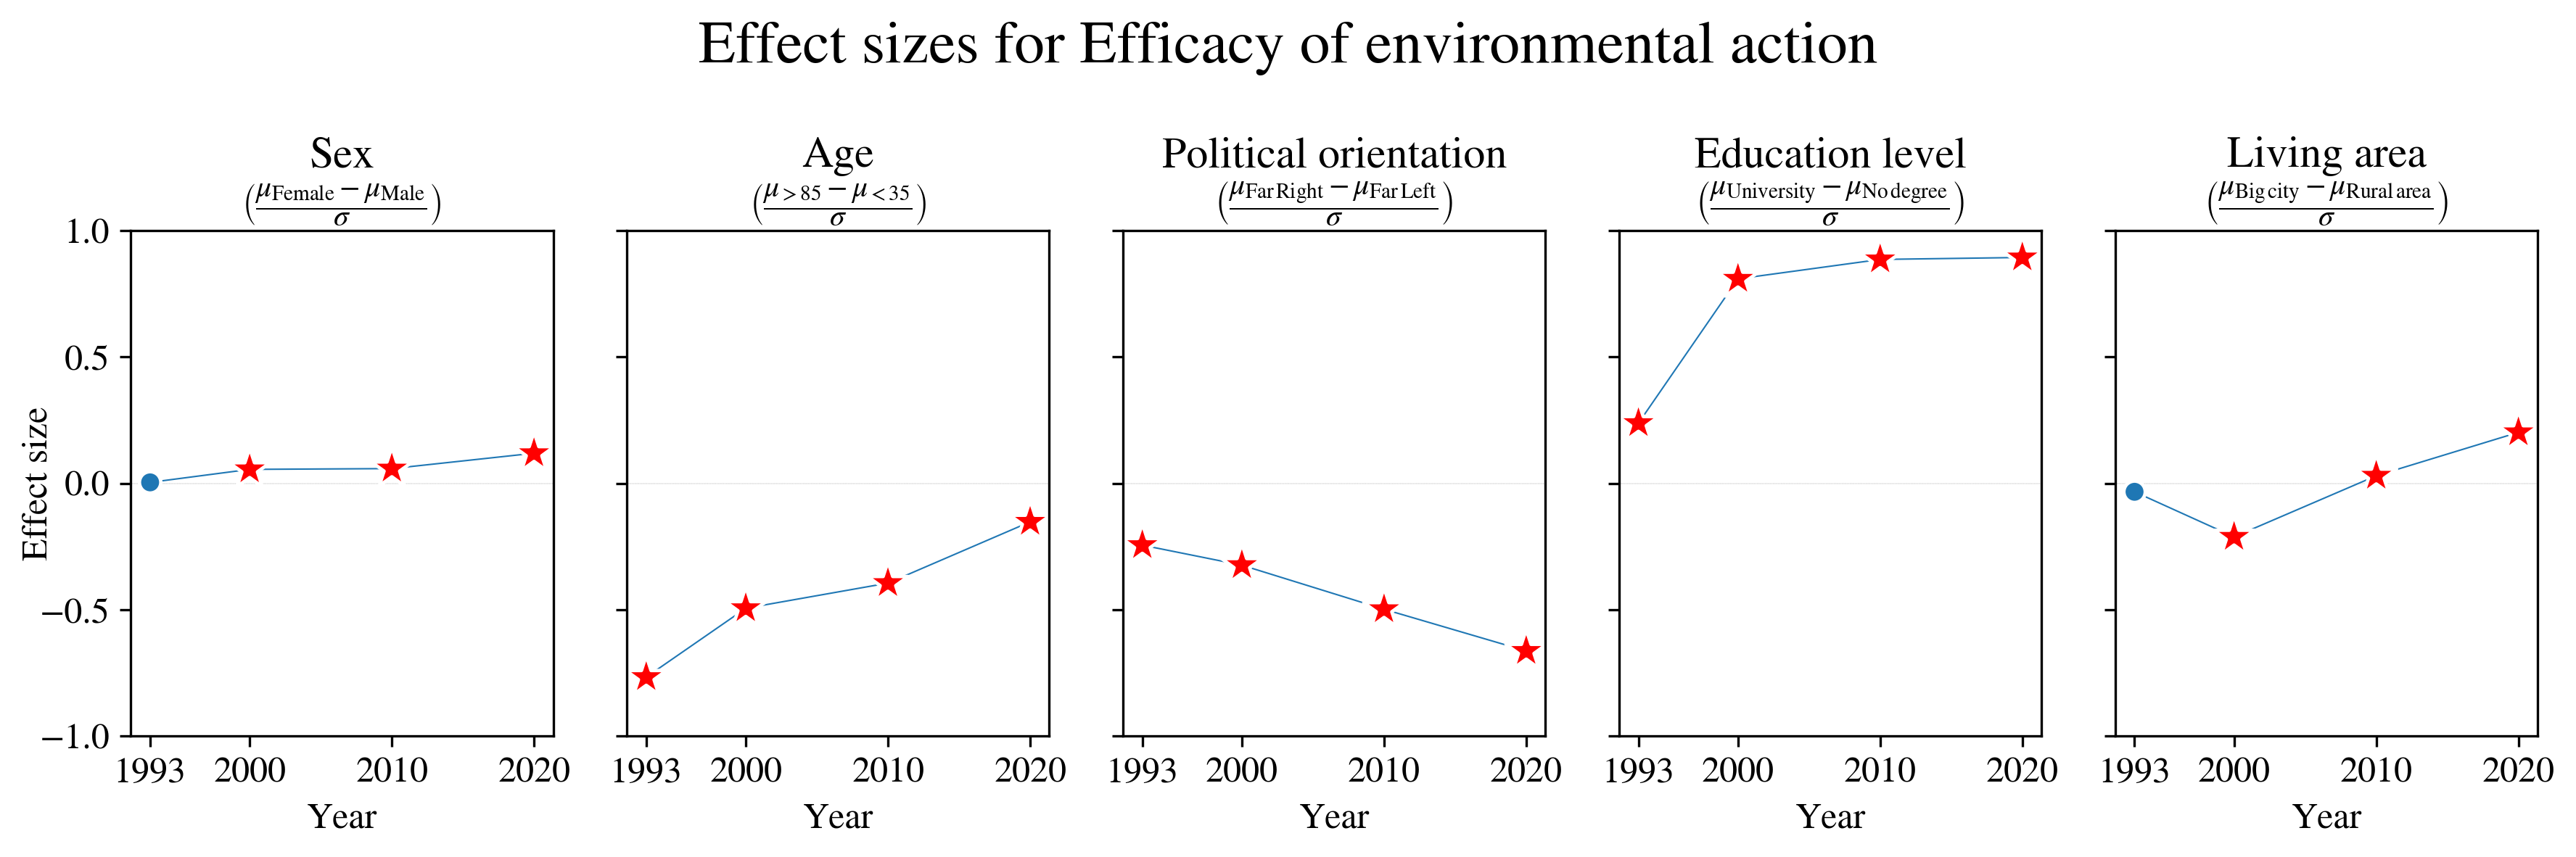

In [124]:
#plot effect size vs years for individual data
indic_to_plot = {
    "Sex" : ["== 'Female'", " == 'Male'"],
    "Age" : [">85", "<35"],
    "Political orientation" : ["=='Far Right'", "=='Far Left'"],
    "Education level" : ["=='University'", "=='No degree'"],
    "Living area" : ["== 'Big city'", " == 'Rural area'"],
}

effect_size_labels = {
    "Sex" : r"$\left(\dfrac{\mu_{\mathrm{Female}}-\mu_{\mathrm{Male}}}{\sigma}\right)$",
    "Age" : r"$\left(\dfrac{\mu_{>85}-\mu_{<35}}{\sigma}\right)$",
    "Political orientation" : r"$\left(\dfrac{\mu_{\mathrm{Far\,Right}}-\mu_{\mathrm{Far\,Left}}}{\sigma}\right)$",
    "Education level" : r"$\left(\dfrac{\mu_{\mathrm{University}}-\mu_{\mathrm{No\,degree}}}{\sigma}\right)$",
    "Living area" : r"$\left(\dfrac{\mu_{\mathrm{Big\,city}}-\mu_{\mathrm{Rural\,area}}}{\sigma}\right)$",
}   

effect_size_ylabels = {
    "Sex" : r"$\frac{\mu_{\mathrm{Female}}-\mu_{\mathrm{Male}}}{\sigma}$",
    "Age" : r"$\frac{\mu_{<35}-\mu_{>85}}{\sigma}$",
    "Political orientation" : r"$\frac{\mu_{\mathrm{Far\,Right}}-\mu_{\mathrm{Far\,Left}}}{\sigma}$",
    "Education level" : r"$\frac{\mu_{\mathrm{No\,degree}}-\mu_{\mathrm{University}}}{\sigma}$",
    "Living area" : r"$\frac{\mu_{\mathrm{Big\,city}}-\mu_{\mathrm{Rural\,area}}}{\sigma}$",
}   


for topic in full_dataset.loc[:,"Environmental concern dimension"].columns:
    size_x, size_y = plt.rcParams["figure.figsize"]
    fig, axs = plt.subplots(1, 5, figsize=(2*size_x, size_y), sharey=True)
    fig.suptitle(f"Effect sizes for {topic}", size=20)
    for i, indicator in enumerate(indic_to_plot.keys()):
        effect_sizes = []
        significant = []
        for year in [1993, 2000, 2010, 2020]:
            df = full_dataset.droplevel(axis=1, level=0).loc[year, [indicator, topic]]

            eff_size = (df.query(f"`{indicator}` {indic_to_plot[indicator][0]}")[topic].mean() - df.query(f"`{indicator}` {indic_to_plot[indicator][1]}")[topic].mean()) / df[topic].std()
            p_val = kruskal(df.query(f"`{indicator}` {indic_to_plot[indicator][0]}")[topic], df.query(f"`{indicator}` {indic_to_plot[indicator][1]}")[topic])[1]
            
            effect_sizes.append(eff_size)
            significant.append("Significant" if p_val < 0.05 else "Not significant")

            del(df)

        #plot
        ax = axs[i]
        ax.axline((1993,0,),(2020,0), lw=0.1, ls='--', color="gray", zorder=0)
        sns.lineplot(x=[1993, 2000, 2010, 2020], y=effect_sizes, lw=0.5, ax=ax, zorder=1)
        sns.scatterplot(x=[1993, 2000, 2010, 2020], y=effect_sizes, style=significant, hue=significant, palette = {"Significant" : "red", "Not significant" : sns.color_palette("tab10")[0]}, markers = {"Significant" : "*", "Not significant" : "."}, s=200, style_order=["Significant", "Not significant"], hue_order=["Significant", "Not significant"], ax=ax)
        
        ax.set_title(f"{indicator}\n")
        ax.text(0.5,1.03, f"{effect_size_labels[indicator]}", ha="center", fontsize=10, transform=ax.transAxes)
        ax.set_ylabel("Effect size", loc="center", labelpad=-5)
        #ax.set_ylabel(f"{effect_size_ylabels[indicator]}", labelpad=-5)
        ax.set_xticks([1993,2000,2010,2020])
        ax.set_xlabel("Year", loc="center")


        ax.set_yticks([-1. , -0.5,  0. ,  0.5,  1. ])
        ax.set_ylim((-1, 1))
        
        if i>0 or True:# or topic!="Awareness":
            ax.get_legend().remove()
        plt.tight_layout()
        

    plt.savefig(f"../PaperFigures/effectSizes_{titleTopic[topic]}_vs_microInd.pdf", format="pdf")   

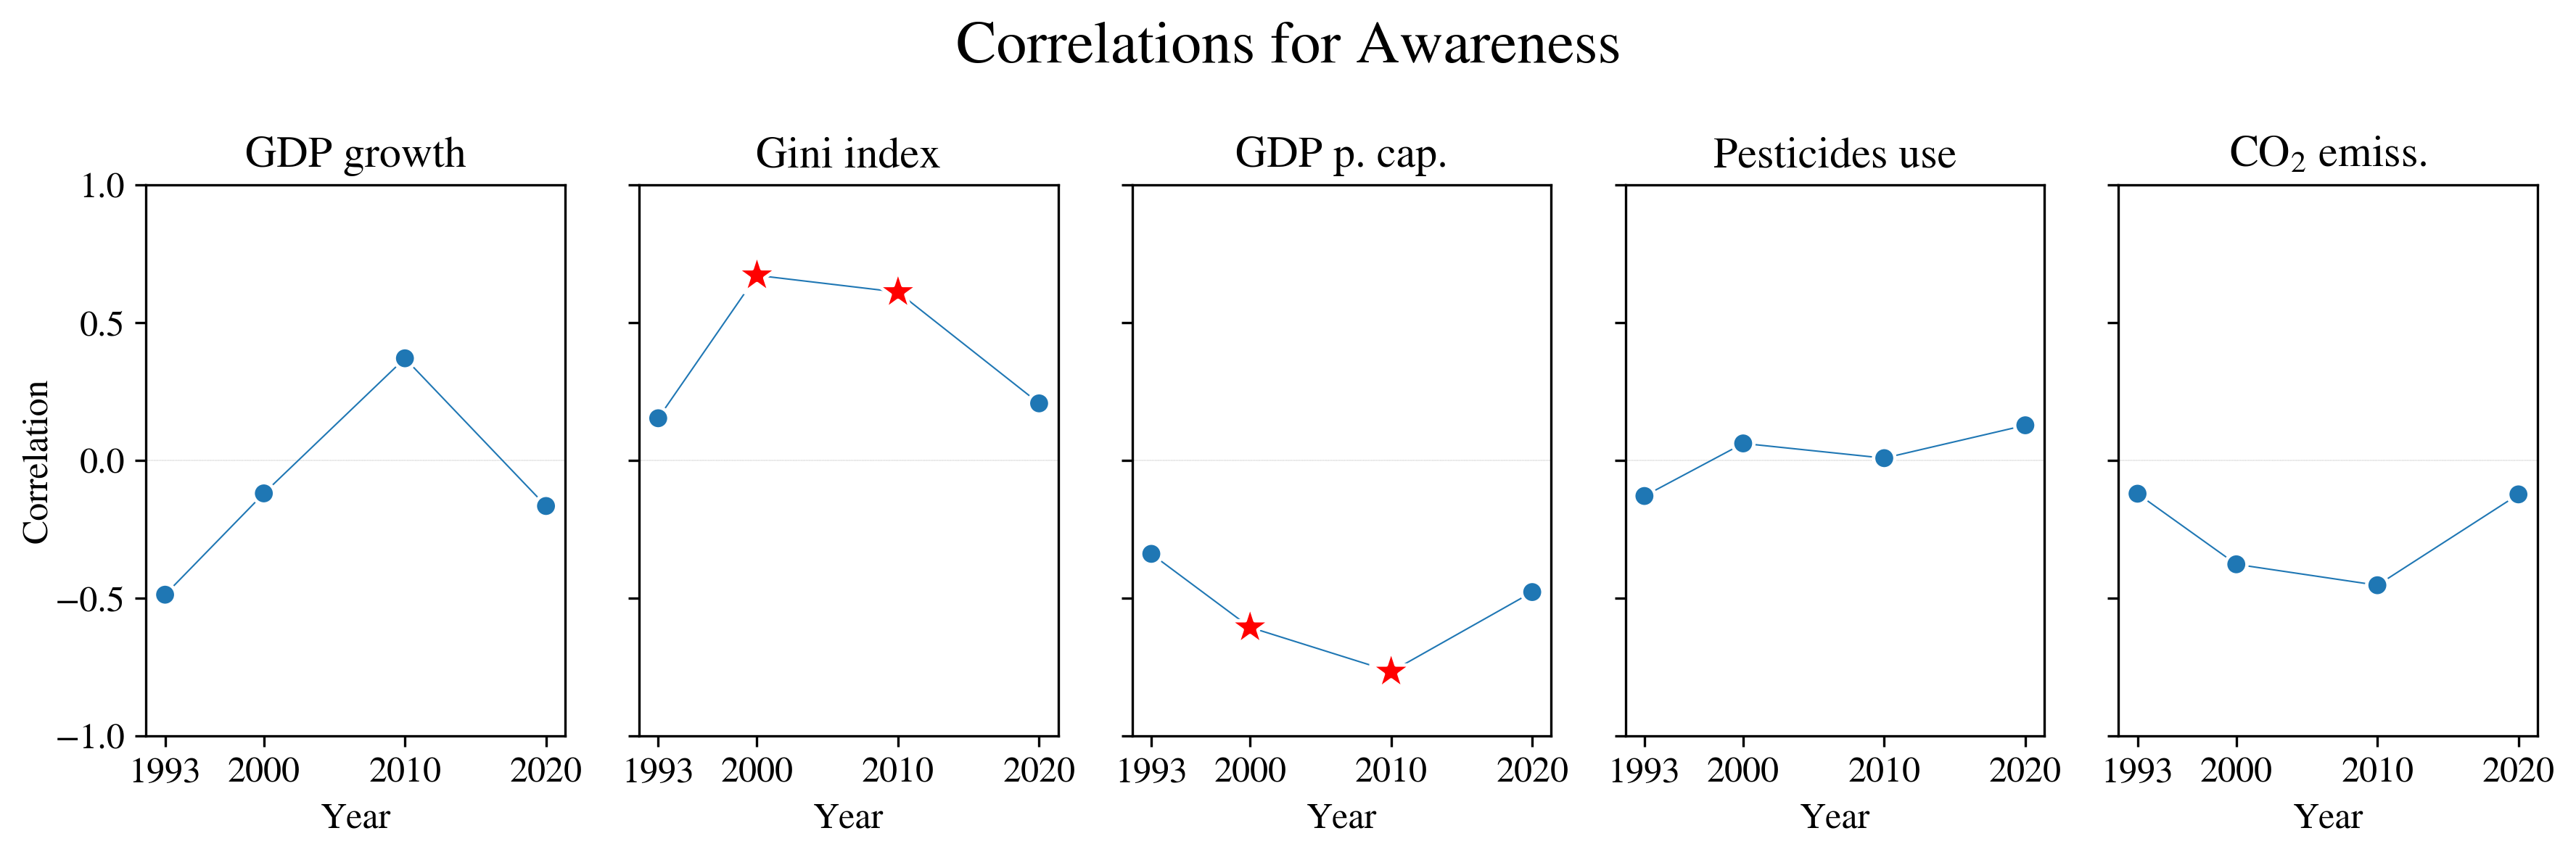

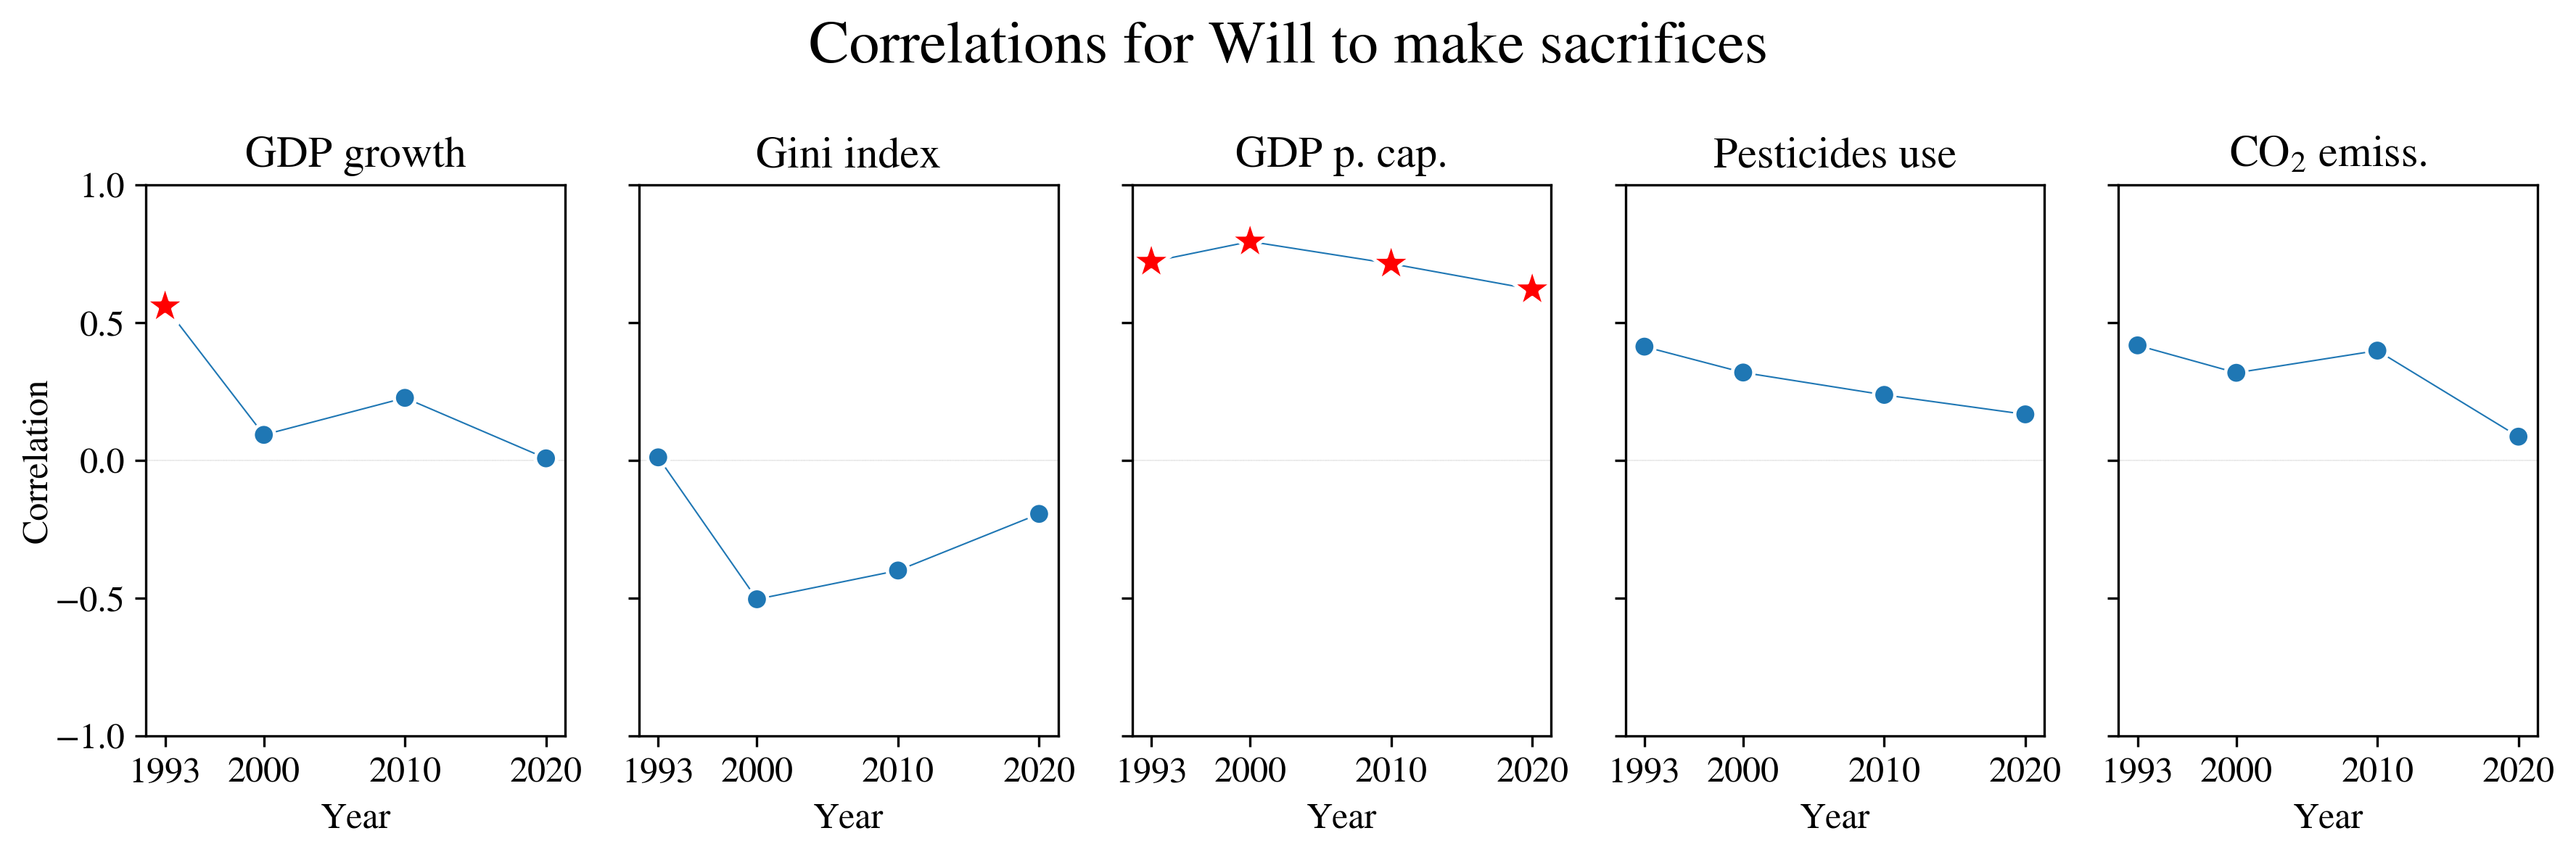

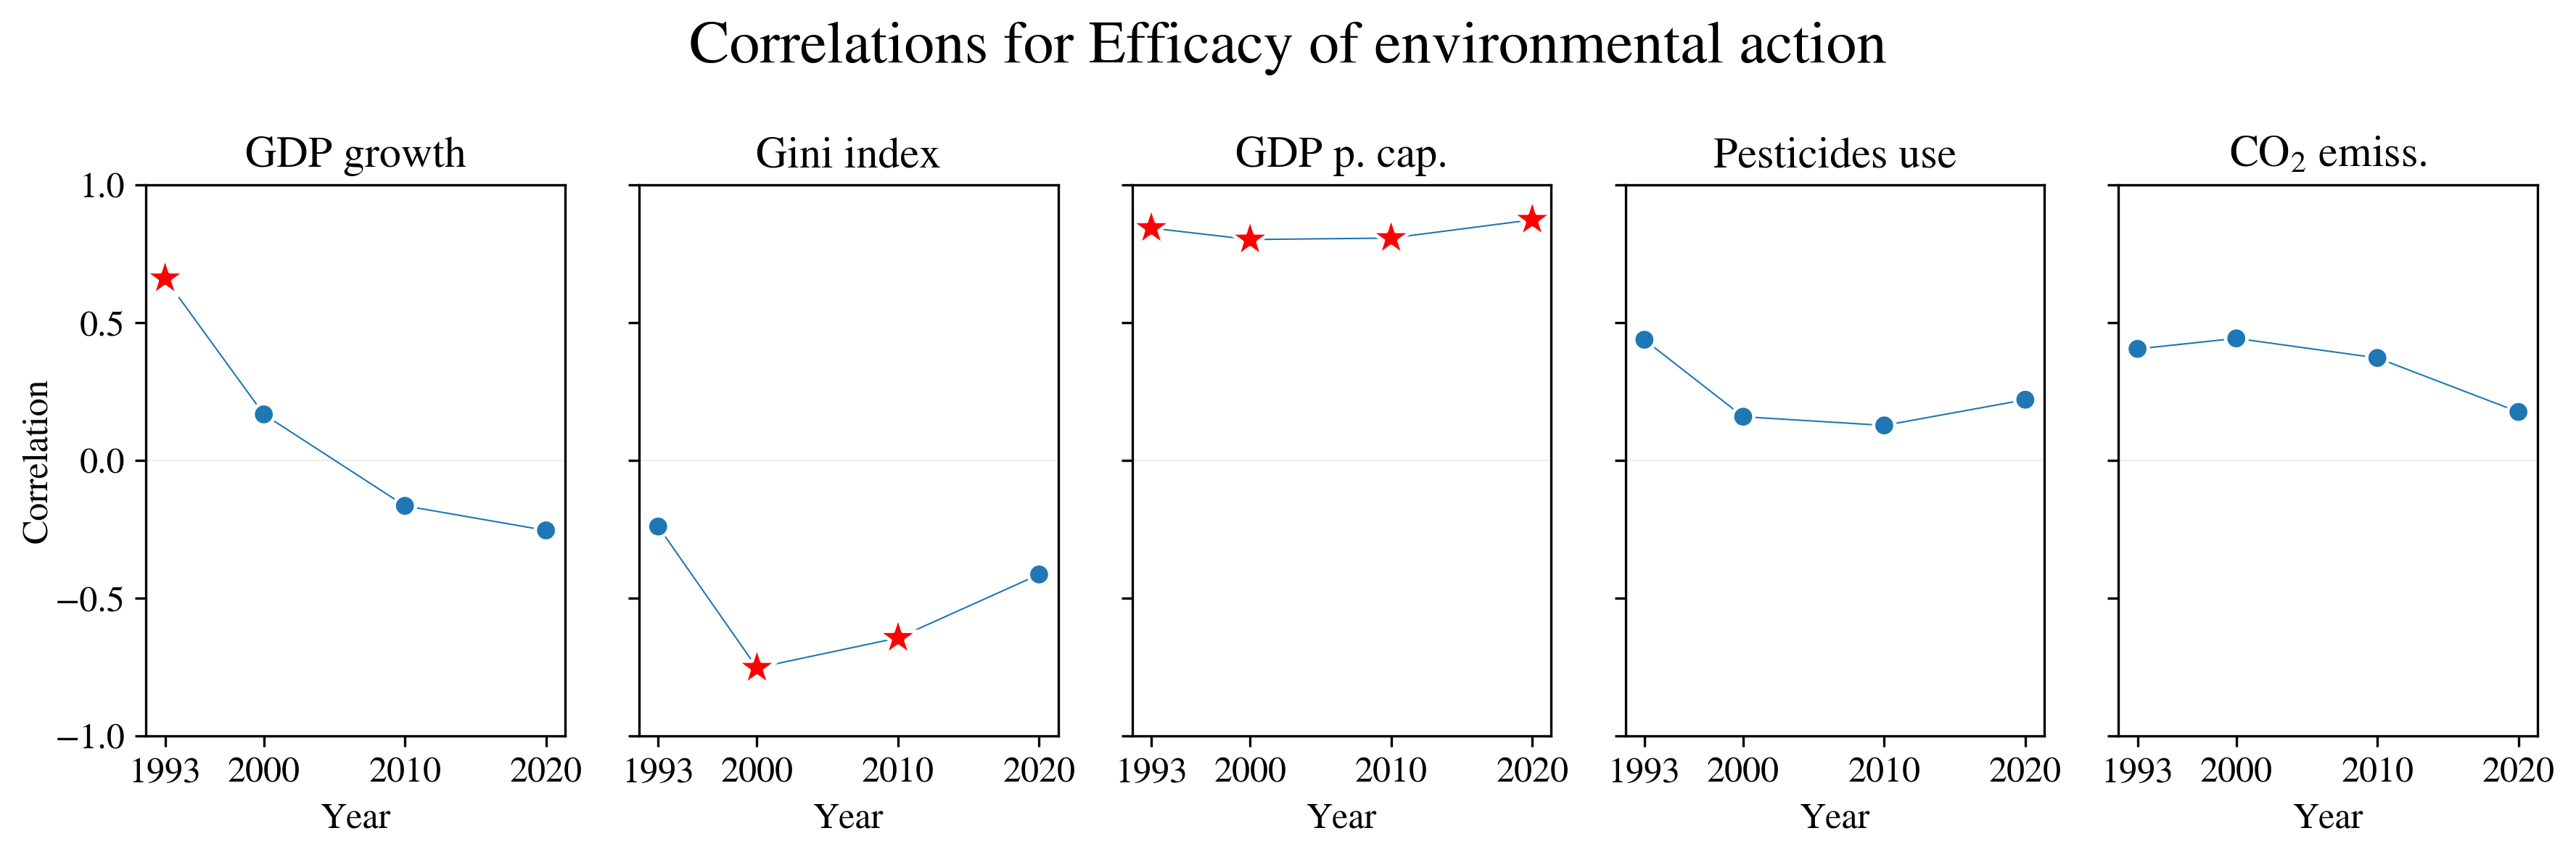

In [125]:
#plot correlation vs years for country-wide data
for topic in full_dataset.loc[:,"Environmental concern dimension"].columns:
    size_x, size_y = plt.rcParams["figure.figsize"]
    fig, axs = plt.subplots(1, 5, figsize=(2*size_x, size_y), sharey=True)
    fig.suptitle(f"Correlations for {topic}", size=20)
    for i, indicator in enumerate(["GDP growth", "Gini index", "GDP per capita (Purchasing Power Parity)", "Pesticides use", "CO2 emissions per capita"]):
        correlations = []
        significant = []
        for year in [1993, 2000, 2010, 2020]:
            df = full_dataset.droplevel(axis=1, level=0).loc[year, [indicator, topic]].groupby("Country").mean()

            corr = df.corr().loc[indicator, topic]
            
            model = LinearRegression()
            model.fit(df.dropna()[[indicator]], df.dropna()[topic])
            R2 = model.score(df.dropna()[[indicator]], df.dropna()[topic])
            
            correlations.append(corr)
            significant.append(r"Significant $(R^2>0.3)$" if R2 > 0.3 else "Not significant")

            del(df)

        #plot
        ax = axs[i]
        ax.axline((1993,0,),(2020,0), lw=0.1, ls='--', color="gray", zorder=0)
        sns.lineplot(x=[1993, 2000, 2010, 2020], y=correlations, lw=0.5, ax=ax, zorder=1)
        sns.scatterplot(x=[1993, 2000, 2010, 2020], y=correlations, style=significant, hue=significant, palette = {r"Significant $(R^2>0.3)$" : "red", "Not significant" : sns.color_palette("tab10")[0]}, markers = {r"Significant $(R^2>0.3)$" : "*", "Not significant" : "."}, s=200, style_order=[r"Significant $(R^2>0.3)$", "Not significant"], hue_order=[r"Significant $(R^2>0.3)$", "Not significant"], ax=ax)

        corr_labels = {
            "GDP per capita (Purchasing Power Parity)" : "GDP p. cap.",
            "CO2 emissions per capita" : r"CO${}_2$ emiss.",
            "PM25 exposure" : r"PM${}_{25}$ exp."
        }
        ax.set_title(f"{corr_labels.get(indicator, indicator)}")
        ax.set_xticks([1993,2000,2010,2020])
        ax.set_xlabel("Year", loc="center")

        ax.set_ylabel("Correlation", labelpad=0, loc="center")

        ax.set_yticks([-1. , -0.5,  0. ,  0.5,  1. ])
        ax.set_ylim((-1, 1))
        
        
        if i>0 or True:
            ax.get_legend().remove()
        plt.tight_layout()

    plt.savefig(f"../PaperFigures/correlations_{titleTopic[topic]}_vs_macroInd.pdf", format="pdf")